In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import sklearn
%matplotlib inline

In [2]:
basic = pd.read_csv('start.csv')

In [41]:
basic.shape

(836759, 29)

In [42]:
basic.head(4)

,visitStartTime,fullVisitorId,visitNumber,browser,operatingSystem,deviceCategory,month,day,hour,weekday,...,subContinent,city,region,metro,hits,newVisits,pageviews,medium,isTrueDirect,transactionRevenue
0,2016-09-03 06:24:50,9703195967386511074,1,Edge,Windows,desktop,9,3,6,5,...,Eastern Europe,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,True,2,organic,True,0.0
1,2016-09-02 22:29:32,5264054794625558679,2,Safari,iOS,mobile,9,2,22,4,...,Northern America,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,False,2,organic,True,0.0
2,2016-09-02 17:56:45,791674562423114515,1,Opera,Windows,desktop,9,2,17,4,...,Eastern Europe,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,True,2,organic,True,0.0
3,2016-09-02 16:16:36,1346279730040488573,1,Chrome,iOS,mobile,9,2,16,4,...,Southern Europe,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,True,2,organic,True,0.0


## 1. Boundry of training/testing data 
- So we already filter only rows with bounce = 0 for both train & test
- The following row is the first row of test data with bounce = 0
- rows before index 453023 are training data, rows since index 453023 are test data

In [43]:
basic.loc[453023]

visitStartTime        2017-10-16 10:50:24
fullVisitorId         6167871330617112363
visitNumber                             2
browser                            Chrome
operatingSystem                 Macintosh
deviceCategory                    desktop
month                                  10
day                                    16
hour                                   10
weekday                                 0
is_weekend                          False
month_sin                       -0.866025
month_cos                             0.5
hour_sin                              0.5
hour_cos                        -0.866025
day_sin                         -0.101168
day_cos                         -0.994869
continent                            Asia
country                         Singapore
subContinent               Southeast Asia
city                            (not set)
region                          (not set)
metro                           (not set)
hits                              

In [44]:
basic.columns

Index(['visitStartTime', 'fullVisitorId', 'visitNumber', 'browser',
       'operatingSystem', 'deviceCategory', 'month', 'day', 'hour', 'weekday',
       'is_weekend', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'continent', 'country', 'subContinent', 'city',
       'region', 'metro', 'hits', 'newVisits', 'pageviews', 'medium',
       'isTrueDirect', 'transactionRevenue'],
      dtype='object')

## 2. Categorical encoding
- We provided a function that can get the dummy variable of a specific column with top n counts
- I.e., if a column has 6 classes, and you want only 4 classes, you can use our function to combine the 4th - 6th class into one class
- Please see the example below
- Meanwhile, there're many options for categorical encoding, which I found this place quite helpful
- http://contrib.scikit-learn.org/categorical-encoding/

In [3]:
def topn_class(dataset, column_name:str, num:int):
    # column_name must be a string, num is the top n classes you wanna leave in total
    column = pd.get_dummies(dataset[column_name])
    new_feature_df = column.copy()
    df = pd.DataFrame(np.sum(new_feature_df, axis=0))
    
    temp_list = list((df.sort_values(by = 0, ascending=False).index))
    try:
        temp_list.remove('(not set)')
    except:
        pass
    separated_category = temp_list[0:num]
    
    combined_category = list(set(new_feature_df.columns) - set(separated_category))
    new_feature_df['Other'] = new_feature_df[combined_category].sum(axis = 1)
    new_feature_df = new_feature_df.drop(combined_category, axis=1)
    
    return(new_feature_df)

In [46]:
topn_class(basic,'browser', 10).head()

,Android Webview,Chrome,Edge,Firefox,Internet Explorer,Opera,Opera Mini,Safari,Safari (in-app),Samsung Internet,Other
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [47]:
b = topn_class(basic,'browser', 10)

In [48]:
o = topn_class(basic,'operatingSystem', 7)

In [50]:
sample_merge = pd.concat([basic, b, o], axis=1, join='inner').head()
sample_merge

,visitStartTime,fullVisitorId,visitNumber,browser,operatingSystem,deviceCategory,month,day,hour,weekday,...,Samsung Internet,Other,Android,Chrome OS,Linux,Macintosh,Windows,Windows Phone,iOS,Other
0,2016-09-03 06:24:50,9703195967386511074,1,Edge,Windows,desktop,9,3,6,5,...,0,0,0,0,0,0,1,0,0,0
1,2016-09-02 22:29:32,5264054794625558679,2,Safari,iOS,mobile,9,2,22,4,...,0,0,0,0,0,0,0,0,1,0
2,2016-09-02 17:56:45,791674562423114515,1,Opera,Windows,desktop,9,2,17,4,...,0,0,0,0,0,0,1,0,0,0
3,2016-09-02 16:16:36,1346279730040488573,1,Chrome,iOS,mobile,9,2,16,4,...,0,0,0,0,0,0,0,0,1,0
4,2016-09-02 22:54:25,8770237469311081313,1,Chrome,Macintosh,desktop,9,2,22,4,...,0,0,0,0,0,1,0,0,0,0


## 3. Numerical processing
- We provided a function that can create several bins for a specific numeric column
- Reference: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
- You can also play around with other methods, like normalization

In [4]:
def bins(dataset, column_name:str, num:int, method:str):
    # column_name must be a string, num is the total bins you wanna assign to in total
    # method also has to be a string, with two options: 'qcut'(same bin size) or 'cut' (close value in the same bin)
    if method == 'qcut':
        category = pd.qcut(dataset[column_name],num)
        category = category.to_frame()
    elif method == 'cut':
        category = pd.cut(dataset[column_name],num)
        category = category.to_frame()
    else:
        print('please type a correct method, whether qcut or cut.')
    return category

In [5]:
# Here is an example
bins(basic, 'hits', 5, 'qcut').head()

,hits
0,"(0.999, 2.0]"
1,"(0.999, 2.0]"
2,"(0.999, 2.0]"
3,"(0.999, 2.0]"
4,"(0.999, 2.0]"


## Here is a reference about train/test
- Feel free to use any cv on training set
- Just keep in mind what is the test set for your prediction target

## 4. LGBM Model training 
- To train LGBM model, convert categorical feature first

In [5]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [86]:
#You should convert your categorical features to int type before you construct Dataset
#DataFrame.dtypes for data must be int, float or bool.
#visitStartTime, browser, operatingSystem, deviceCategory, continent, country, subContinent, city, region, metro, medium
train = basic.copy()
train['fullVisitorId'] = train['fullVisitorId'].astype('float')
train = train.drop('visitStartTime', axis=1)

In [87]:
train['browser'] = train['browser'].astype('category')
train['operatingSystem'] = train['operatingSystem'].astype('category')
train['deviceCategory'] = train['deviceCategory'].astype('category')
train['continent'] = train['continent'].astype('category')
train['country'] = train['country'].astype('category')
train['subContinent'] = train['subContinent'].astype('category')
train['city'] = train['city'].astype('category')
train['region'] = train['region'].astype('category')
train['metro'] = train['metro'].astype('category')
train['medium'] = train['medium'].astype('category')

In [88]:
# cross_validation to test data
train_only = train.loc[0:453022,:] 
train_data = train_only.drop('transactionRevenue', axis=1)
train_target = train_only['transactionRevenue']
#train_target_ln = np.log(train_target+1)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=i)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

In [128]:
run_lgb(X_train, X_test, y_train, y_test)

Start training...
[1]	valid_0's l2: 6.68793	valid_0's auc: 0.957957
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 6.11648	valid_0's auc: 0.965674
[3]	valid_0's l2: 5.8471	valid_0's auc: 0.965363
[4]	valid_0's l2: 5.65425	valid_0's auc: 0.965826
[5]	valid_0's l2: 5.54801	valid_0's auc: 0.965354
[6]	valid_0's l2: 5.4777	valid_0's auc: 0.965979
[7]	valid_0's l2: 5.43148	valid_0's auc: 0.966024
[8]	valid_0's l2: 5.41153	valid_0's auc: 0.965662
[9]	valid_0's l2: 5.39678	valid_0's auc: 0.966079
[10]	valid_0's l2: 5.38357	valid_0's auc: 0.965131
[11]	valid_0's l2: 5.3711	valid_0's auc: 0.966584
[12]	valid_0's l2: 5.38734	valid_0's auc: 0.965397
[13]	valid_0's l2: 5.3951	valid_0's auc: 0.965802
[14]	valid_0's l2: 5.39731	valid_0's auc: 0.964907
[15]	valid_0's l2: 5.40194	valid_0's auc: 0.964475
[16]	valid_0's l2: 5.42078	valid_0's auc: 0.965452
Early stopping, best iteration is:
[11]	valid_0's l2: 5.3711	valid_0's auc: 0.966584
Start predicting...
The rmse of p

2.317562538826323

In [127]:
#simple lgbm model
#create dataset for lightgbm
def run_lgb(X_train, X_test, y_train, y_test):
    
    lgb_train = lgb.Dataset(X_train, y_train, feature_name=list(X_train.columns),
                        categorical_feature=['browser', 'operatingSystem', 
                                             'deviceCategory', 'continent', 'country', 'subContinent', 
                                             'city', 'region', 'metro', 'medium'])
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
    params = {'task': 'train',
              'boosting_type': 'gbdt', 
              'objective': 'regression',
              'metric': {'l2', 'auc'},
              'num_leaves': 120, 
              'learning_rate': 0.27,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.5,
              'bagging_freq': 100,
              'verbose': 0}
    print('Start training...')
# train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=20,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    print('Start predicting...')
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    return rmse

In [34]:
test = pd.read_csv('./data/test.csv')

In [35]:
device = pd.DataFrame(test["device"].apply(json.loads).tolist(),index = test.index)
geo = pd.DataFrame(test["geoNetwork"].apply(json.loads).tolist(),index = test.index)
total = pd.DataFrame(test["totals"].apply(json.loads).tolist(),index = test.index)
traffic = pd.DataFrame(test["trafficSource"].apply(json.loads).tolist(),index = test.index)
#merge json info back to dataset 
js_col =  ['device', 'geoNetwork','totals','trafficSource']
test = test.drop(columns=js_col)
js_df = ['device','geo','total','traffic']
for i in js_df:
    data_name = i
    test = pd.merge(test,vars()[data_name],left_index=True,right_index=True)

In [ ]:
len(test.groupby)

In [54]:
test_pred = test.copy()

In [55]:
test_pred['bounces']= test_pred["bounces"].fillna(0)

In [56]:
test_pred['bounces'].value_counts()

1    420948
0    383736
Name: bounces, dtype: int64

In [57]:
test_pred['Revenue'] = np.where(test_pred['bounces']=='1',0,np.nan)

In [39]:
X_train.shape

(362418, 27)

In [42]:
X_test = train.loc[453023:,:]
#y_test = X_test["transactionRevenue"]
X_test =X_test.drop("transactionRevenue",axis=1)

In [37]:
X_test.head()

,fullVisitorId,visitNumber,browser,operatingSystem,deviceCategory,month,day,hour,weekday,is_weekend,...,country,subContinent,city,region,metro,hits,newVisits,pageviews,medium,isTrueDirect
453023,6.167871e+18,2,Chrome,Macintosh,desktop,10,16,10,0,False,...,Singapore,Southeast Asia,(not set),(not set),(not set),4,False,4,organic,True
453024,6.436976e+17,1,Chrome,Windows,desktop,10,16,17,0,False,...,Spain,Southern Europe,Zaragoza,Aragon,(not set),5,True,5,organic,True
453025,6.059384e+18,1,Chrome,Macintosh,desktop,10,16,8,0,False,...,France,Western Europe,not available in demo dataset,not available in demo dataset,not available in demo dataset,7,True,7,organic,True
453026,2.376720e+18,1,Safari,iOS,mobile,10,16,22,0,False,...,United States,Northern America,Mountain View,California,San Francisco-Oakland-San Jose CA,8,True,4,organic,True
453027,2.314545e+18,1,Safari,Macintosh,desktop,10,17,5,1,False,...,United States,Northern America,San Jose,California,San Francisco-Oakland-San Jose CA,9,True,4,organic,True


In [43]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

(array([3.80274e+05, 3.09200e+03, 2.80000e+02, 6.30000e+01, 1.20000e+01,
        3.00000e+00, 4.00000e+00, 1.00000e+00, 5.00000e+00, 2.00000e+00]),
 array([-6.90973486e+07,  4.18048358e+07,  1.52707020e+08,  2.63609205e+08,
         3.74511389e+08,  4.85413573e+08,  5.96315758e+08,  7.07217942e+08,
         8.18120126e+08,  9.29022311e+08,  1.03992450e+09]),
 <a list of 10 Patch objects>)

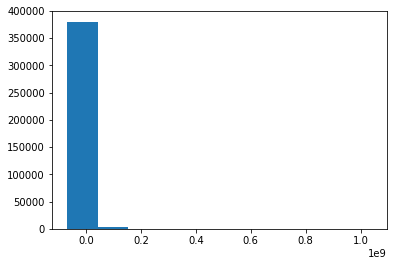

In [44]:
plt.hist(y_pred)

In [92]:
len(y_pred[y_pred<=0.55])

356960

In [93]:
y_pred[y_pred<=0.55] = 0

In [52]:
sample_sub = pd.read_csv("./data/sample_submission.csv")

In [61]:

y_pred_2.shape
#out = y_pred_2[['fullVisitorId','Revenue_y']]
#out.columns = ['fullVisitorId','PredictedLogRevenue']

(804684, 51)

In [62]:

out.head()

,fullVisitorId,PredictedLogRevenue
0,6167871330617112363,853015.778582
1,0643697640977915618,853015.778582
2,6059383810968229466,853015.778582
3,2376720078563423631,853015.778582
4,2314544520795440038,853015.778582


In [83]:
# out put data by combining with sample dataset
# need rephrase; sooooo ugly now!
ind = pd.Series(test_pred[test_pred['bounces']==0].index)
indx = pd.Series(ind)
pred = pd.DataFrame(y_pred,index=ind)
new = pd.DataFrame(indx)
new['Revenue'] = pred
y_pred_2 = pd.merge(test_pred,new,left_index=True,right_on=0, how = "outer")
y_pred_2["Revenue_y"]= y_pred_2["Revenue_y"].fillna(0)
out = y_pred_2[['fullVisitorId','Revenue_y']]
out.columns = ['fullVisitorId','PredictedLogRevenue']
out_2 = pd.DataFrame(out.groupby('fullVisitorId')['PredictedLogRevenue'].sum())
out_2.columns = ['PredictedLogRevenue']
#out_2['PredictedLogRevenue'] = np.log(out_2['PredictedLogRevenue'] + 1)
#out_3 = out_2.to_frame()
out_4 = pd.merge(sample_sub,out_2,left_on="fullVisitorId",right_index=True,how='left')
out_4 = out_4.drop('PredictedLogRevenue_x',axis=1)
out_4.columns = ['fullVisitorId','PredictedLogRevenue']
out_4['PredictedLogRevenue'] = out_4['PredictedLogRevenue'].fillna(0)
#out_4.to_csv("basic_sub_2.csv",index=False)

In [85]:
out_4.to_csv("basic_sub_2.csv",index=False)

In [84]:
out_4.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.000000
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,13.656534
